In [1]:
from __future__ import division, unicode_literals, print_function  # for compatibility with Python 2 and 3

import matplotlib as mpl
import matplotlib.pyplot as plt

# change the following to %matplotlib notebook for interactive plotting
%matplotlib inline

# Optionally, tweak styles.
mpl.rc('figure',  figsize=(10, 6))
#mpl.rc('image', cmap='gray')
import numpy as np
import pandas as pd
from pandas import DataFrame, Series  # for convenience

import pims
import trackpy as tp
from pims import Frame

In [2]:
## Step 1: Load tif file
v = pims.TiffStack('/Users/pinghanchu/Documents/Git/Data/Shot119_Cam_18333.tif')
print(type(v))

<class 'pims.tiff_stack.TiffStack_tifffile'>


/Users/pinghanchu/anaconda/lib/python2.7/site-packages/tifffile/tifffile.py:2126: UserWarning: invalid page offset > file size
  warnings.warn("invalid page offset > file size")


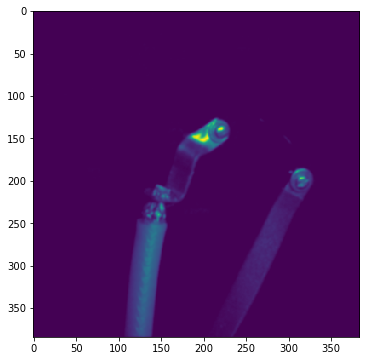

In [3]:
## Step 2: Generate background frame from the first frame
## Apply bandpass to filter out noise pixel

v0 = tp.bandpass(v[0],1, 300)
plt.imshow(v0)

70.2909879574


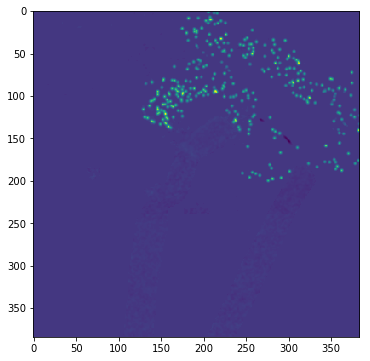

In [4]:
## Step 3 : Substrace each frame from the background frame
## Each frame needs to filter out noise pixel
vi = tp.bandpass(v[1000],1,300)-v0
print(np.max(vi))
plt.imshow(vi)

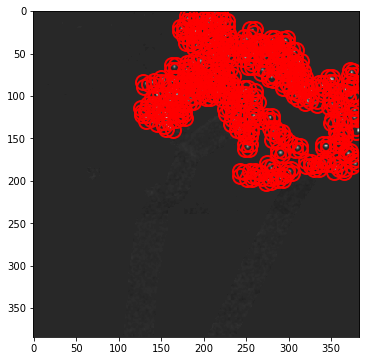

In [5]:
## Step 4 : Locate particles
f = tp.locate(vi, 3, invert=True)
plt.figure()  # make a new figure
tp.annotate(f, vi);

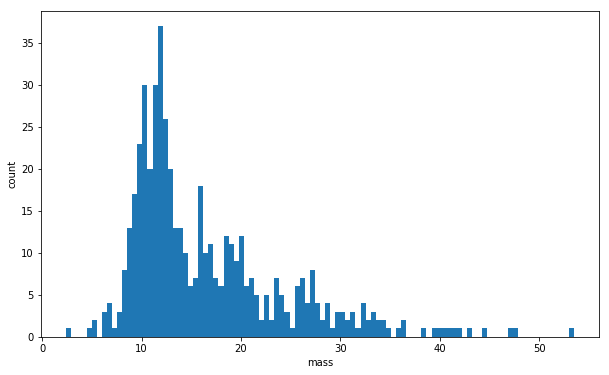

In [6]:
## Step 5 : Refine parameters to elminate spurious features
## Plot histogram of pixel
fig, ax = plt.subplots()
ax.hist(f['mass'], bins=100)
# Optionally, label the axes.
ax.set(xlabel='mass', ylabel='count');

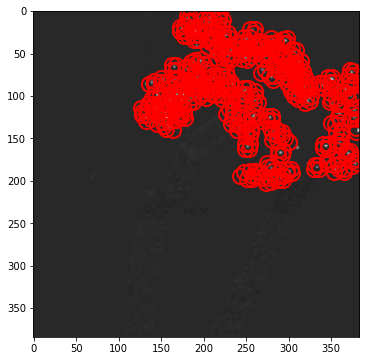

In [7]:
## Step 6 : Apply a cut at minmass == 10
f = tp.locate(vi, 3, invert=True, minmass=10)
plt.figure()  # make a new figure
tp.annotate(f, vi);

In [8]:
##Data points
f.head()

,x,y,mass,size,ecc,signal,raw_mass,ep
0,218.945205,0.969178,15.786318,0.866025,0.155251,3.946579,2.662501,26.201180
1,180.007968,6.079681,13.569746,0.865450,0.441489,3.405952,3.742866,4.302330
2,184.050209,6.000000,12.920993,0.858138,0.585227,3.405952,3.156637,7.872816
3,191.075269,6.107527,10.055668,0.867576,0.357143,2.486886,5.000000,2.181102
4,217.986957,5.956522,12.434428,0.867280,0.404624,3.081576,5.000000,2.181102


In [9]:
from scipy.misc import imsave

In [10]:
## Setp 7 : Apply and Save clean frames
## Save individual clear frame into frame_{}.png
ind = 0
for iv in v:
    pln = "frame_{}.png".format(ind)
    vi = tp.bandpass(iv,1,300)-v0
    imsave("/Users/pinghanchu/Documents/Git/Data/Clean_Data_Shot119_Cam_18333/frame_{}.png".format(ind),vi)
    ind = ind+1    

In [11]:
## Step 8: Load png file
frames = pims.ImageSequence('/Users/pinghanchu/Documents/Git/Data/Clean_Data_Shot119_Cam_18333/frame_*.png', as_grey=True)

In [12]:
## Step 9: Locate features in all frames
f = tp.batch(frames[400:3000], 11, minmass=10, invert=True);

Frame 2999: 81 features


In [13]:
## Step 10: Link features into particle trajectories
t = tp.link_df(f, 5, memory=3)

Frame 2999: 81 trajectories present


In [14]:
## Step 11: Filter spurious trajectories.
t1 = tp.filter_stubs(t, 10)
# Compare the number of particles in the unfiltered and filtered data.
print('Before:', t['particle'].nunique())
print('After:', t1['particle'].nunique())

Before: 39228
After: 3183


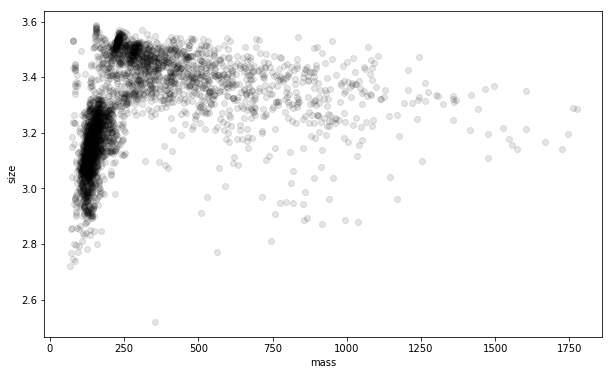

In [15]:
## feature's "average appearance" throughout its trajectory, giving a more accurate picture.
plt.figure()
tp.mass_size(t1.groupby('particle').mean()); # convenience function -- just plots size vs. mass

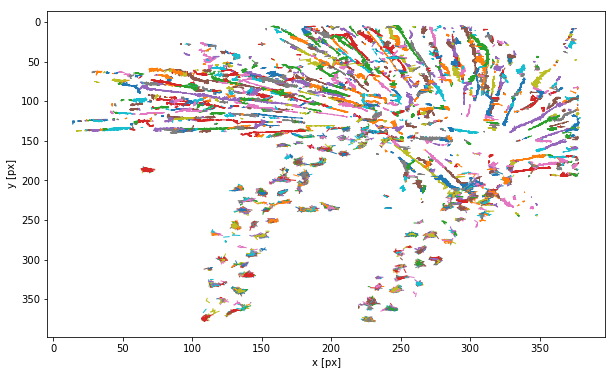

In [16]:
## Trace the trajectories.
plt.figure()
tp.plot_traj(t1)

In [17]:
## data
t1.head()

,x,y,mass,size,ecc,signal,raw_mass,ep,frame,particle
frame,,,,,,,,,,
400,235.646856,47.476503,500.072028,3.217040,0.066207,12.614118,17462.0,-0.006418,400,0.0
401,235.720501,46.803933,555.264492,3.259441,0.085311,13.401795,17666.0,-0.006413,401,0.0
402,235.663642,46.831821,534.793345,3.257127,0.082523,13.517136,17571.0,-0.010559,402,0.0
403,235.621553,46.763550,559.957718,3.245965,0.094553,14.376094,17634.0,-0.014701,403,0.0
406,235.550329,46.496368,521.844261,3.240611,0.083588,13.718493,17170.0,-0.013253,406,0.0


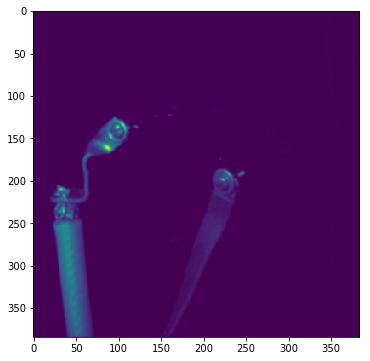

In [25]:
# Step 12: Repeat other camera 
u = pims.TiffStack('/Users/pinghanchu/Documents/Git/Data/Shot119_Cam_18158.tif')
u0 = tp.bandpass(u[0],1, 300)
plt.imshow(u0)

In [26]:
ind = 0
for iu in u:
    pln = "frame_{}.png".format(ind)
    ui = tp.bandpass(iu,1,300)-u0
    imsave("/Users/pinghanchu/Documents/Git/Data/Clean_Data_Shot119_Cam_18158/frame_{}.png".format(ind),ui)
    ind = ind+1    

In [27]:
frames2 = pims.ImageSequence('/Users/pinghanchu/Documents/Git/Data/Clean_Data_Shot119_Cam_18158/frame_*.png', as_grey=True)
f2 = tp.batch(frames2[400:3000], 11, minmass=10, invert=True);

Frame 2999: 101 features


Frame 2999: 101 trajectories present
Before: 28893
After: 2710


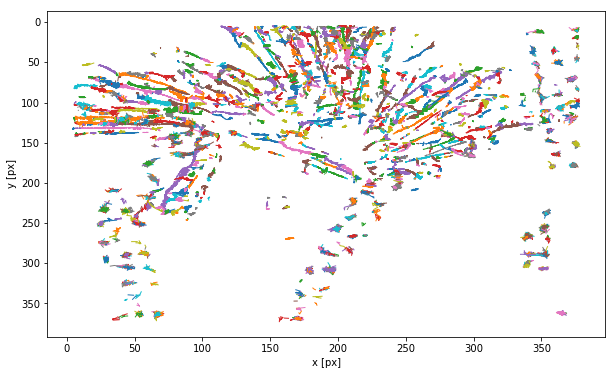

In [28]:
s = tp.link_df(f2, 5, memory=3)
## Step 11: Filter spurious trajectories.
s1 = tp.filter_stubs(s, 10)
# Compare the number of particles in the unfiltered and filtered data.
print('Before:', s['particle'].nunique())
print('After:', s1['particle'].nunique())
plt.figure()
tp.plot_traj(s1)